In [1]:
# basic libraries
import pandas as pd
import numpy as np
import calendar
# visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')

In [2]:
fig=go.Figure()
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.6, 1.6, 1.6, 1.6],
    mode="text", 
    text=["<span style='font-size:33px'><b>54</b></span>", 
          "<span style='font-size:33px'><b>33</b></span>",
          "<span style='font-size:33px'><b>16</b></span>",
          "<span style='font-size:33px'><b>56</b></span>"],
    textposition="bottom center"
))
fig.add_trace(go.Scatter(
    x=[0, 1, 2, 3],
    y=[1.1, 1.1, 1.1, 1.1],
    mode="text", 
    text=["Stores", "Products", "States", "Months"],
    textposition="bottom center"
))
fig.add_hline(y=2.2, line_width=5, line_color='gray')
fig.add_hline(y=0.3, line_width=3, line_color='gray')
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=False, height=300, width=700, 
                  title='Store Sales Summary', title_x=0.5, title_y=0.9,
                  xaxis_range=[-0.5,3.6], yaxis_range=[-0.2,2.2],
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  font=dict(size=23, color='#323232'),
                  title_font=dict(size=35, color='#222'),
                  margin=dict(t=90,l=70,b=0,r=70), 
    )

The dataset is about store sales forecasting where contaning 54 stores, having 33 family of products and 3 years of data

In [3]:
# path for dataset
from pathlib import Path
comp_dir = Path(r'D:\Python(New)\Project\Store_Sales_Time_Series_Forecasting\data')
# load dataset
train_data = pd.read_csv(comp_dir / 'train.csv',index_col = False)
test_data = pd.read_csv(comp_dir / 'test.csv')

holiday_data = pd.read_csv(comp_dir / 'holidays_events.csv')
oil_data = pd.read_csv(comp_dir / 'oil.csv')
stores_data = pd.read_csv(comp_dir / 'stores.csv')
trans_data = pd.read_csv(comp_dir / 'transactions.csv')


In [4]:
# find out how many stores, products, states and months in the dataset:
# train data
print(f"Number of unique stores is: {train_data['store_nbr'].nunique()} stores")
print(f"Number of unique products is: {train_data['family'].nunique()} products")
print(f"Total days in the train dataset is: {len(train_data)/ 54 / 33} days")
print(f"Starting date of the train dataset is: {train_data['date'].min()}")
print(f"Ending date of the train dataset is: {train_data['date'].max()}")

# test data
print(f"Total days in the test dataset is: {len(test_data)/ 54 / 33} days")
print(f"Starting date of the test dataset is: {test_data['date'].min()}")
print(f"Ending date of the test dataset is: {test_data['date'].max()}")



Number of unique stores is: 54 stores
Number of unique products is: 33 products
Total days in the train dataset is: 1684.0 days
Starting date of the train dataset is: 2013-01-01
Ending date of the train dataset is: 2017-08-15
Total days in the test dataset is: 16.0 days
Starting date of the test dataset is: 2017-08-16
Ending date of the test dataset is: 2017-08-31


In [5]:
# merge train data with other data
df_train = train_data.merge(holiday_data, how='left', on=['date'])
df_train = df_train.merge(oil_data, how='left', on=['date'])
df_train = df_train.merge(stores_data, how='left', on=['store_nbr'])
df_train = df_train.merge(trans_data, how='left', on=['date', 'store_nbr'])
df_train = df_train.rename(columns = {"type_x":"holiday_type","type_y": "store_type"})

# change date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
# add month and year column
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year
# add week column
df_train['week'] = df_train['date'].dt.isocalendar().week
# add quarter column
df_train['quarter'] = df_train['date'].dt.quarter
# add day of week column
df_train['day_of_week'] = df_train['date'].dt.day_name()
# read the data head
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,...,city,state,store_type,cluster,transactions,month,year,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,1,2013,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,1,2013,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,1,2013,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,1,2013,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,...,Quito,Pichincha,D,13,NaN,1,2013,1,1,Tuesday


In [6]:
# check the data info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054348 entries, 0 to 3054347
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   holiday_type  object        
 7   locale        object        
 8   locale_name   object        
 9   description   object        
 10  transferred   object        
 11  dcoilwtico    float64       
 12  city          object        
 13  state         object        
 14  store_type    object        
 15  cluster       int64         
 16  transactions  float64       
 17  month         int64         
 18  year          int64         
 19  week          UInt32        
 20  quarter       int64         
 21  day_of_week   object        
dtypes: UInt32(1), datetime64[ns](1), float64(3), int64(7), object(10)


In [7]:
# check the data description
df_train.describe()

,id,store_nbr,sales,onpromotion,dcoilwtico,cluster,transactions,month,year,week,quarter
count,3.054348e+06,3.054348e+06,3.054348e+06,3.054348e+06,2.099196e+06,3.054348e+06,2.805231e+06,3.054348e+06,3.054348e+06,3054348.0,3.054348e+06
mean,1.504277e+06,2.750000e+01,3.590209e+02,2.617480e+00,6.801587e+01,8.481481e+00,1.697071e+03,6.222870e+00,2.014842e+03,25.308635,2.413652e+00
std,8.662610e+05,1.558579e+01,1.107286e+03,1.225494e+01,2.569134e+01,4.649735e+00,9.668317e+02,3.374251e+00,1.345607e+00,14.750509,1.095690e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.619000e+01,1.000000e+00,5.000000e+00,1.000000e+00,2.013000e+03,1.0,1.000000e+00
25%,7.546768e+05,1.400000e+01,0.000000e+00,0.000000e+00,4.641000e+01,4.000000e+00,1.046000e+03,3.000000e+00,2.014000e+03,13.0,1.000000e+00
50%,1.507572e+06,2.750000e+01,1.100000e+01,0.000000e+00,5.343000e+01,8.500000e+00,1.395000e+03,6.000000e+00,2.015000e+03,25.0,2.000000e+00
75%,2.255120e+06,4.100000e+01,1.960110e+02,0.000000e+00,9.581000e+01,1.300000e+01,2.081000e+03,9.000000e+00,2.016000e+03,38.0,3.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02,1.106200e+02,1.700000e+01,8.359000e+03,1.200000e+01,2.017000e+03,53.0,4.000000e+00


In [8]:
# check missing values
df_train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
month                 0
year                  0
week                  0
quarter               0
day_of_week           0
dtype: int64

In [9]:
# fill holiday_type missing values with 'Work Day' 
df_train['holiday_type'] = df_train['holiday_type'].fillna('No Information')
# fill locale missing values with 'No Information'
df_train['locale'] = df_train['locale'].fillna('No Information')
# fill locale_name missing values with 'No Information'
df_train['locale_name'] = df_train['locale_name'].fillna('No Information')
# fill description missing values with 'No Information'
df_train['description'] = df_train['description'].fillna('No Information')
# fill transferred missing values with 'No Information'
df_train['transferred'] = df_train['transferred'].fillna('No Information')
# fill oil_price missing values with mean value
df_train['dcoilwtico'] = df_train['dcoilwtico'].fillna(df_train['dcoilwtico'].mean())
# fill transactions missing values with median value
df_train['transactions'] = df_train['transactions'].fillna(df_train['transactions'].median())

## Average Sale Analysis

In [25]:
# data
store_type_sales = df_train.groupby('store_type')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)
family_sales = df_train.groupby('family')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)[:10]
cluster_sales = df_train.groupby('cluster')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)

# chart color
family_sales['color'] = '#496595'
family_sales['color'].iloc[2:] = '#c6ccd8' 
cluster_sales['color'] = '#c6ccd8'

# visualization
fig = make_subplots(rows=2 , cols=2,
                    specs=[[{"type":"bar"}, {"type":"pie"}],
                           [{"colspan": 2},None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales","Highest Sales in Stores","Highest Sales by Cluster"))
# family sales
fig.add_trace(go.Bar(x=family_sales['sales'], y=family_sales['family'], marker=dict(color= family_sales['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
# store type sales
fig.add_trace(go.Pie(values=store_type_sales['sales'], labels=store_type_sales['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
#cluster_sales
fig.add_trace(go.Bar(x=cluster_sales['cluster'], y=cluster_sales['sales'], 
                     marker=dict(color= cluster_sales['color']), name='Cluster'), 
                     row=2, col=1)
# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=cluster_sales.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=40, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=25, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Highest sales are made by grocery and beverage products and store A has the highest sales which is 38% 

## Average Sales Analysis for Year-Month

In [11]:
# data
data_2013 = df_train[df_train['year'] == 2013][['month','sales']].groupby('month')['sales'].mean().reset_index().rename(columns={'sales':'2013'})
data_2014 = df_train[df_train['year'] == 2014][['month','sales']].groupby('month')['sales'].mean().reset_index().rename(columns={'sales':'2014'})
data_2015 = df_train[df_train['year'] == 2015][['month','sales']].groupby('month')['sales'].mean().reset_index().rename(columns={'sales':'2015'})
data_2016 = df_train[df_train['year'] == 2016][['month','sales']].groupby('month')['sales'].mean().reset_index().rename(columns={'sales':'2016'})
data_2017 = df_train[df_train['year'] == 2017][['month','sales']].groupby('month')['sales'].mean().reset_index()
data_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
data_2017 =  pd.concat([data_2017, data_2017_no], ignore_index=True).rename(columns={'sales':'2017'})
data_year = data_2013.merge(data_2014, on='month').merge(data_2015, on='month').merge(data_2016, on='month').merge(data_2017, on='month')

In [12]:
# visualization
# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']
colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

# X axis value
data_year = data_year[['2013','2014','2015','2016','2017']].replace(np.nan, 0)
x_data = data_year.values

# Y axis value
data_2013['month'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = data_2013['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))
        fig.update_layout(title='Average Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=25,
                                      color='rgb(37,150,190)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=25,
                                          color='rgb(37,150,190)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=25,
                                                  color='rgb(37, 150, 190)'),
                                        showarrow=False))
            space += xd[i]
            fig.update_layout(
    annotations=annotations)
fig.show()                            


Highest sales are made in December and then decrecrease in January. Sales are increasing gradually from 2013 - 2017. Note: we don't have data for 2017: 9th - 12th month 

## Average Sales Analysis: Time Series

In [13]:
# data
month_sales = df_train[['month','sales']].groupby('month')['sales'].mean().reset_index()
month_sales['sales'] = round(month_sales['sales'], 2)
month_sales['month_text'] = month_sales['month'].apply(lambda x: calendar.month_abbr[x])
month_sales['text'] = month_sales['month_text'] + ' - ' + month_sales['sales'].astype(str)

week_sales = df_train[['week','sales']].groupby('week')['sales'].mean().reset_index()
quarter_sales = df_train[['quarter','sales']].groupby('quarter')['sales'].mean().reset_index()

In [14]:
# chart color
month_sales['color'] = '#496595'
month_sales['color'][:-1] = '#c6ccd8'
week_sales['color'] = '#c6ccd8'

# visualization
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Average Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))
# month sales
fig.add_trace(go.Bar(x=month_sales['sales'], y=month_sales['month'], marker=dict(color= month_sales['color']),
                     text=month_sales['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
# quarter sales
fig.add_trace(go.Pie(values=quarter_sales['sales'], labels=quarter_sales['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
# week sales
fig.add_trace(go.Scatter(x=week_sales['week'], y=week_sales['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=week_sales.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                    margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()


The chart above shows that sales have been consistently increasing over time, despite fluctuations at various points. The fluctuations appear to occur in a somewhat regular pattern, suggesting the presence of a seasonal trend. To gain a better understanding of this pattern, it would be useful to analyze data from specific years. One notable finding is that the highest sales occur on Sundays, while December has the highest overall sales. However, it should be noted that data is missing for the last four months of 2017.

## Store Analysis

In [35]:
# data
store_holiday = df_train.groupby(['store_type','holiday_type'])['sales'].mean().reset_index()
store_holiday['sales'] = round(store_holiday['sales'], 2)


# visualization and save fig
fig = px.scatter(store_holiday, x='store_type', color='sales', y='holiday_type', size='sales',
                 color_discrete_sequence=px.colors.qualitative.Pastel,
                 title="Average Sales: Store Type Vs Holiday Type")

# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()


In [16]:
# data
year_month_store = df_train.groupby(['year','month','store_type'])['sales'].mean().reset_index()
year_month_store['sales'] = round(year_month_store['sales'], 2)

# visualization
fig = px.scatter(year_month_store, x='month', y='store_type', color='sales', size='sales',
                 facet_row='year', title = 'Average Sales: Store Type Vs Year(Month)')

# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

In [17]:
# data
month_holiday = df_train.groupby(['month','holiday_type'])['sales'].mean().reset_index()
month_holiday['sales'] = round(month_holiday['sales'], 2)

# visualization
fig = px.scatter(month_holiday, x='month', y='holiday_type', color='sales', size='sales',
                    color_discrete_sequence=px.colors.qualitative.Pastel,
                    title="Average Sales: Holiday Type Vs Month")

# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=400, xaxis_title='', yaxis_title='',
                  margin=dict(b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()

The chart indicates that the highest sales were recorded during transfer holidays, particularly in November (pre-Christmas), December (Christmas holiday), and January (New Year holiday). Additionally, there is a significant shopping trend in May.

In [18]:
# data
year_month_holiday = df_train.groupby(['year','month','holiday_type'])['sales'].mean().reset_index()
year_month_holiday['sales'] = round(year_month_holiday['sales'], 2)

# visualization
fig = px.scatter(year_month_holiday, x='month', y='holiday_type', color='sales', size='sales',
                    facet_row='year', title = 'Average Sales: Holiday Type Vs Year(Month)')

# styling
fig.update_yaxes(ticksuffix='  ')
fig.update_xaxes(tickmode = 'array', tickvals=[i for i in range(1,13)], 
                 ticktext=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
fig.update_layout(height=900, xaxis_title='', yaxis_title='',
                  margin=dict(t=70, b=0),
                  plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                  title_font=dict(size=29, color='#444', family="Lato, sans-serif"),
                  font=dict(color='#555'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"))
fig.show()



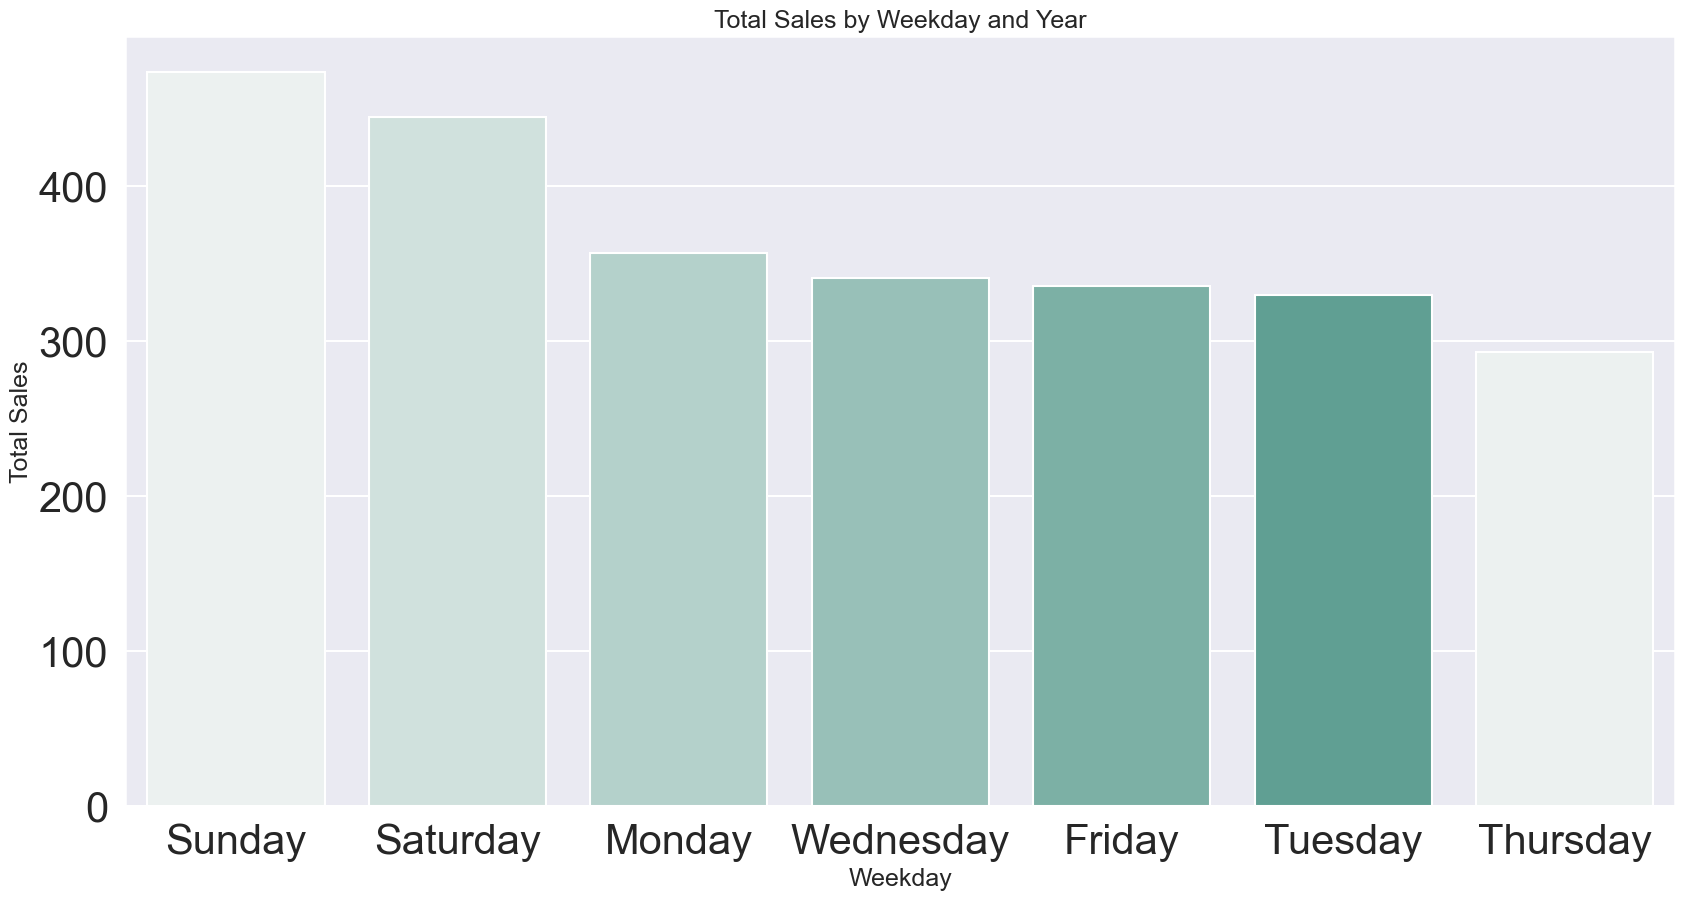

In [19]:
# group data by weekday and year, and sum the sales
weekday_year_sales = df_train.groupby(['day_of_week', 'year'])['sales'].mean().sort_values(ascending = False).reset_index()
# create a bar plot of total sales by weekady and year
plt.figure(figsize=(20, 10))
colour = sns.color_palette("light:#5A9", as_cmap=False)
sns.barplot(data=weekday_year_sales, x='day_of_week', y='sales', errorbar= None, palette = colour)
plt.xlabel('Weekday')
plt.ylabel('Total Sales')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title('Total Sales by Weekday and Year')
plt.savefig("D:\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\Total Sales by Weekday and Year.png")
plt.show()

Sunday and Saturday are the days with the highest sales and Thurdasy is the days with the lowest sales.

## Average Sales by Cities Analysis

In [36]:
# data
store_type_sales = df_train.groupby('store_type')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)
city_sales = df_train.groupby('city')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)[:10]
state_sales = df_train.groupby('state')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)

# chart color
city_sales['color'] = '#496595'
city_sales['color'].iloc[2:] = '#c6ccd8' 
state_sales['color'] = '#c6ccd8'

# visualization
fig = make_subplots(rows=2 , cols=2,
                    specs=[[{"type":"bar"}, {"type":"pie"}],
                           [{"colspan": 2},None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 City Has Highest Sales","Highest Sales in Stores", "Highest Sales in States"))
# city sales
fig.add_trace(go.Bar(x=city_sales['sales'], y=city_sales['city'], marker=dict(color= city_sales['color']),
                     name='City', orientation='h'), 
                     row=1, col=1)
# store type sales
fig.add_trace(go.Pie(values=store_type_sales['sales'], labels=store_type_sales['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
#state_sales
fig.add_trace(go.Bar(x=state_sales['state'], y=state_sales['sales'], 
                     marker=dict(color= state_sales['color']), name='State'), 
                     row=2, col=1)
# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=state_sales.state)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales by Cities Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Quito and Cayambe in Pichincha are the cities with the highest sales.

## Average Oil Price Analysis


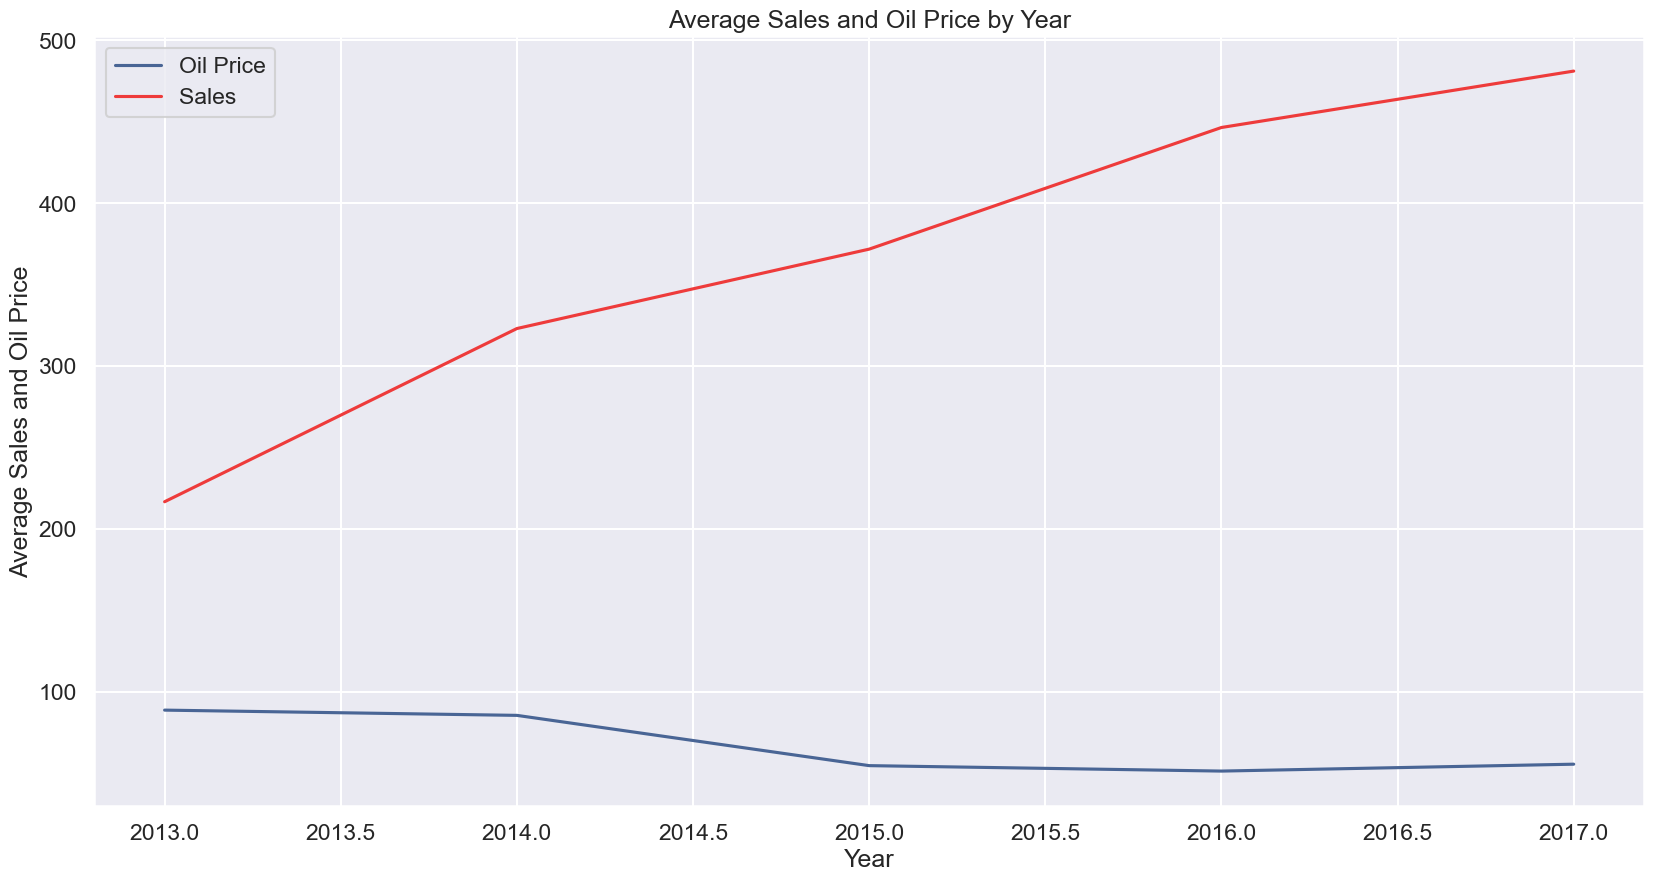

In [37]:
# data
oil_year = df_train.groupby(['year'])[['dcoilwtico','sales']].mean().reset_index()

# visualization
plt.figure(figsize=(20, 10))
sns.lineplot(data=oil_year, x='year', y='dcoilwtico', color='#496595', label='Oil Price')
sns.lineplot(data=oil_year, x='year', y='sales', color='#EE3B3B', label='Sales')
plt.xlabel('Year')
plt.ylabel('Average Sales and Oil Price')
plt.title('Average Sales and Oil Price by Year')
plt.savefig("D:\\Python(New)\\Project\\Store_Sales_Time_Series_Forecasting\\output\\figures\\Average_Sales_and_Oil_Price_by_Year.png")
plt.show()

In [22]:
# Pearson Correlation between Sales and Oil Price
print('Pearson Correlation between Sales and Oil Price: ', df_train['sales'].corr(df_train['dcoilwtico']))

Pearson Correlation between Sales and Oil Price:  -0.05786950383268409


There is a negative correlation between oil price and sales. The chart above shows that the average oil price has been decreasing over time which lead to increase in sales. Note: we don't have data for 2017: 9th - 12th month

In [23]:
# data
month_oil = df_train[['month','dcoilwtico']].groupby('month')['dcoilwtico'].mean().reset_index()
month_oil['dcoilwtico'] = round(month_oil['dcoilwtico'], 2)
month_oil['month_text'] = month_oil['month'].apply(lambda x: calendar.month_abbr[x])
month_oil['text'] =month_oil['month_text'] + ' - ' + month_oil['dcoilwtico'].astype(str)

week_oil = df_train[['week','dcoilwtico']].groupby('week')['dcoilwtico'].mean().reset_index()
quarter_oil = df_train[['quarter','dcoilwtico']].groupby('quarter')['dcoilwtico'].mean().reset_index()

In [38]:
# chart color
month_oil['color'] = '#496595'
month_oil['color'][:-2] = '#c6ccd8'
week_oil['color'] = '#c6ccd8'

# visualization
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Oil Price Analysis", "Quarter wise Avg Oil Price Analysis", 
                                    "Week wise Avg Oil Price Analysis"))
# month sales
fig.add_trace(go.Bar(x=month_oil['dcoilwtico'], y=month_oil['month'], marker=dict(color= month_oil['color']),
                     text=month_oil['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
# quarter sales
fig.add_trace(go.Pie(values=quarter_oil['dcoilwtico'], labels=quarter_oil['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
# week sales
fig.add_trace(go.Scatter(x=week_oil['week'], y=week_oil['dcoilwtico'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=week_sales.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                    margin=dict(b=0,r=20,l=20), 
                  title_text="Average Oil Price Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

December and November are two months with the lowest average oil price. Ecuador is an oil-dependent country, so the decrease in oil price will lead to increase in sales.